In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib
import pandas as pd
import numpy as np
import numba as nb
import talib
import exercise_util

In [2]:
@nb.jit
def calc_position_return(buy_limit_hit, sell_limit_hit, buy_limit, sell_limit, close, force_exit_steps):
  position = np.empty(buy_limit_hit.shape, dtype=float)
  position[:] = 0.0
  
  ret = np.empty(buy_limit_hit.shape, dtype=float)
  ret[:] = 0.0

  _pos = 0.0
  _entry_price = np.nan
  _entry_step = np.nan

  for i in range(position.size):
    _prev_pos = _pos

    if _prev_pos > 0:
      if sell_limit_hit[i] == True:
        # 利確 (手数料は後で計算する)
        _pos = 0.0
        _ret = np.log(sell_limit[i]) - np.log(_entry_price)
      elif force_exit_steps > 0 and i - _entry_step >= force_exit_steps:
        # 強制イグジット
        _pos = 0.0
        _ret = np.log(close[i]) - np.log(_entry_price)
      else:
        # ポジションをそのまま維持
        _pos = _prev_pos
        _ret = 0.0
    elif _prev_pos < 0:
      if buy_limit_hit[i] == True:
        # 利確 (手数料は後で計算する)
        _pos = 0.0
        _ret = -(np.log(buy_limit[i]) - np.log(_entry_price))
      elif force_exit_steps > 0 and i - _entry_step >= force_exit_steps:
        # 強制イグジット
        _pos = 0.0
        _ret = -(np.log(close[i]) - np.log(_entry_price))
      else:
        # ポジションをそのまま維持
        _pos = _prev_pos
        _ret = 0.0
    else:
      if buy_limit_hit[i] == True:
        # ロングでエントリー
        _pos = 1.0
        _ret = 0.0
        _entry_price = buy_limit[i]
        _entry_step = i
      elif sell_limit_hit[i] == True:
        # ショートでエントリー
        _pos = -1.0
        _ret = 0.0
        _entry_price = sell_limit[i]
        _entry_step = i
      else:
        # ポジションをそのまま維持
        _pos = _prev_pos
        _ret = 0.0
    
    position[i] = _pos
    ret[i] = _ret
    
  return position, ret


In [3]:
def simulate_atrkun(symbol = None, df_timebar = None, window_size = 14, atr_factor = 0.5, fee = 0.02, force_exit_steps = 0):
    
    # 描画用のfigureとsubplotを用意 (大量の図を描画してメモリリークを無視できない場合は、plt.FigureとFigure.subplotsを使うこと)
    _figure_rows = 1
    _figure_cols = 3
    #_fig = plt.Figure(figsize = (8 * _figure_cols, 6 * _figure_rows))
    #_axs = _fig.subplots(_figure_rows, _figure_cols, squeeze = False)
    _fig, _axs = plt.subplots(_figure_rows, _figure_cols, squeeze = False, figsize = (8 * _figure_cols, 6 * _figure_rows))
    
    _df_analysis = df_timebar.copy()

    # 1本後の時間足で有効な買指値、売指値を計算してデータフレームに追加
    _df_analysis['atr'] = talib.ATR(_df_analysis['high'], _df_analysis['low'], _df_analysis['close'], timeperiod = window_size) * atr_factor
    _df_analysis['previous_atr'] = _df_analysis['atr'].shift(1)
    _df_analysis['buy_limit'] = (_df_analysis['close'] - _df_analysis['atr']).shift(1)
    _df_analysis['sell_limit'] = (_df_analysis['close'] + _df_analysis['atr']).shift(1)

    _df_analysis['buy_limit_hit'] = _df_analysis['buy_limit'] > _df_analysis['low']
    _df_analysis['sell_limit_hit'] = _df_analysis['sell_limit'] < _df_analysis['high']
    _df_analysis['atr_with_sign'] = 0
    _df_analysis.loc[_df_analysis['buy_limit_hit'] == True, 'atr_with_sign'] = _df_analysis.loc[_df_analysis['buy_limit_hit'] == True, 'previous_atr'] 
    _df_analysis.loc[_df_analysis['sell_limit_hit'] == True, 'atr_with_sign'] = _df_analysis.loc[_df_analysis['sell_limit_hit'] == True, 'previous_atr'] * -1

    _df_analysis['position'], _df_analysis['trade_logreturn'] = calc_position_return(_df_analysis['buy_limit_hit'].values, _df_analysis['sell_limit_hit'].values, _df_analysis['buy_limit'].values,  _df_analysis['sell_limit'].values, _df_analysis['close'].values, force_exit_steps)
    _df_analysis['position_diff'] = _df_analysis['position'].diff()
    _df_analysis.dropna(inplace = True)
    
    # トレードを行うごとに手数料は1回分カウントする
    _df_analysis['fee'] = 0
    _df_analysis.loc[(_df_analysis['position_diff'] != 0.0) & (np.isnan(_df_analysis['position_diff']) == False), 'fee'] = fee * 0.01

    # トレードごとのリターンから手数料を引いて利益を計算
    _df_analysis['profit'] = _df_analysis['trade_logreturn'] - _df_analysis['fee']
    _df_analysis['profit_cumsum'] = _df_analysis['profit'].cumsum()

    # トレードを実行した行のみを抜き出して各種処理を行う
    _df_analysis_tradeonly = _df_analysis[_df_analysis['position_diff'] != 0].copy()
    _df_analysis_tradeonly['time_trade'] = _df_analysis_tradeonly.index
    _df_analysis_tradeonly['interval_trade'] = (_df_analysis_tradeonly['time_trade'].diff() / np.timedelta64(1, "h")).fillna(0).astype(float)
    _df_analysis_tradeonly['profit_trade'] = _df_analysis_tradeonly['profit_cumsum'].diff()

    _df_analysis_tradeonly['gain_trade'] = np.where(_df_analysis_tradeonly['profit_trade'] >= 0, _df_analysis_tradeonly['profit_trade'], 0)
    _df_analysis_tradeonly['loss_trade'] = np.where(_df_analysis_tradeonly['profit_trade'] < 0, _df_analysis_tradeonly['profit_trade'], 0)

    _df_analysis_tradeonly.sort_values(['interval_trade', 'time_trade'], inplace = True)
    _df_analysis_tradeonly.set_index('interval_trade', drop = False, inplace = True)

    # イグジットしたトレードだけを残す
    _df_analysis_tradeonly = _df_analysis_tradeonly.loc[_df_analysis_tradeonly['position'] == 0, :]
    
    _final_profit = _df_analysis['profit_cumsum'].iloc[-1]
    _trade_count = len(_df_analysis_tradeonly)
    _expected_return_per_trade = _df_analysis['profit_cumsum'].iloc[-1] / len(_df_analysis_tradeonly)
    _sd_per_trade = _df_analysis_tradeonly['profit_trade'].std()
    
    # 累積利益の描画
    _ax = _axs[0, 0]
    _ax.plot(_df_analysis.loc[:, 'profit_cumsum'], lw = 0.5)
    _ax.axhline(color = 'red', ls = 'dashed')
    _ax.set_title(f'{symbol} {atr_factor:.1f}ATRくん 累積リターン')
    _ax.grid()

    # ホールド時間とリターンのヒストグラムの描画
    _ax = _axs[0, 1]
    _interval_trade = _df_analysis_tradeonly['interval_trade']
    _profit_trade = _df_analysis_tradeonly['profit_trade'].fillna(0).astype(float)
    _ax.scatter(_interval_trade, _profit_trade, marker = '.')
    _ax.axvline(_interval_trade.quantile(0.25), color = 'red', ls = 'dashed')
    _ax.axvline(_interval_trade.quantile(0.5), color = 'red', ls = 'dashed')
    _ax.axvline(_interval_trade.quantile(0.75), color = 'red', ls = 'dashed')
    _ax.axhline(_profit_trade.quantile(0.25), color = 'red', ls = 'dashed')
    _ax.axhline(_profit_trade.quantile(0.5), color = 'red', ls = 'dashed')
    _ax.axhline(_profit_trade.quantile(0.75), color = 'red', ls = 'dashed')
    _ax.set_title(f'{symbol} {atr_factor:.1f}ATRくん ホールド時間 vs リターン散布図')
    _ax.grid()

    # トレードごとのリターンのヒストグラム (ホールド時間75パーセンタイル以下) の描画
    _ax = _axs[0, 2]
    _ax.plot(_df_analysis_tradeonly['gain_trade'].cumsum(), label = 'gain')
    _ax.plot(-1.0 * _df_analysis_tradeonly['loss_trade'].cumsum(), label = 'loss')
    _ax.axvline(_df_analysis_tradeonly['interval_trade'].quantile(0.25), color = 'red', ls = 'dashed')
    _ax.axvline(_df_analysis_tradeonly['interval_trade'].quantile(0.5), color = 'red', ls = 'dashed')
    _ax.axvline(_df_analysis_tradeonly['interval_trade'].quantile(0.75), color = 'red', ls = 'dashed')
    _ax.set_title(f'{symbol} {atr_factor:.1f}ATRくん 累積リターン (ホールド時間別)')
    _ax.grid()
    _ax.legend()

    _fig.set_tight_layout(True)
    #_fig.savefig(f'threthtune_result_return_{atr_factor:.2f}_fee_{fee:.2f}_force_exit_{force_exit_steps}.png', transparent = False)
    _fig.show()

  0%|          | 0/1149 [00:00<?, ?it/s]

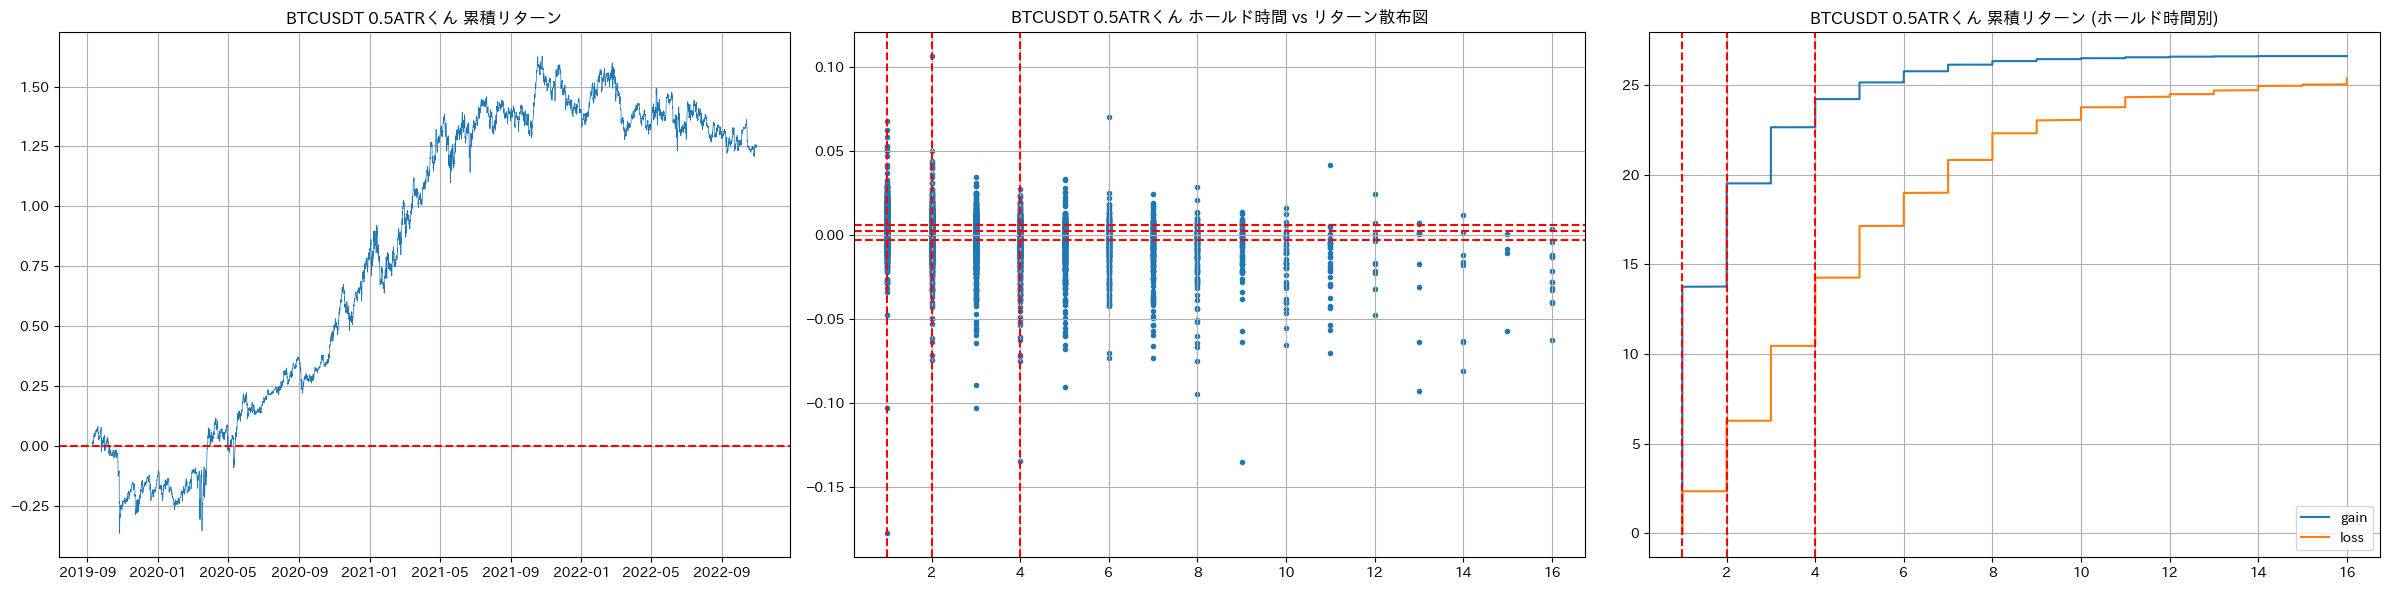

In [5]:
fee = 0.0

df_timebar = exercise_util.concat_timebar_files('BTCUSDT', 3600)

simulate_atrkun('BTCUSDT', df_timebar, window_size = 14, atr_factor = 0.5, fee = fee, force_exit_steps = 16)